# Fake Painting Detection Algorithm - RFC model vs. XGB model

## 1. Random Forest Classifer ("RFC")

### import packages and train data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
data = pd.read_csv('train_dataset.csv', parse_dates=['PurchDate'])
data.head()

,RT13Id,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,PaintingBCost,IsOnlineSale,WarrantyCost
0,21003,0,2010-04-21,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,...,13641.0,14951.0,NaN,NaN,8655,75236,TX,8160.0,0,920
1,57560,0,2009-04-01,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,...,6122.0,7474.0,NaN,NaN,22808,71119,LA,6870.0,0,853
2,29868,0,2010-03-31,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,...,13509.0,15918.0,NaN,NaN,20928,32824,FL,8680.0,0,1373
3,64473,1,2010-06-16,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,...,5243.0,6541.0,NaN,NaN,21053,85226,AZ,4830.0,0,2508
4,68666,0,2010-11-04,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,...,8228.0,9300.0,NaN,NaN,22916,80817,CO,4965.0,0,671


### split into train and test, datasplit into 80/20, set seed

In [2]:
y = data.IsBadBuy
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state = 1)

### the relationship is linear for current retail average price and current retail clean price

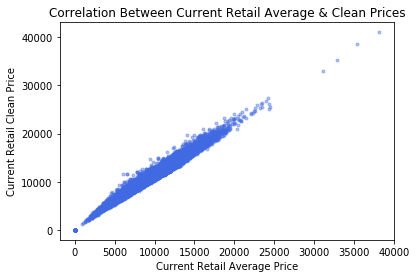

In [3]:
_ = plt.plot(x_train.MMRCurrentRetailAveragePrice, x_train.MMRCurrentRetailCleanPrice, marker='.',
             linestyle='none', color='royalblue', alpha=0.4)
_ = plt.title('Correlation Between Current Retail Average & Clean Prices')
_ = plt.xlabel('Current Retail Average Price')
_ = plt.ylabel('Current Retail Clean Price')
plt.show()

### distribution are skewed for the painting age, bids, warranty costs, acquisitions costs

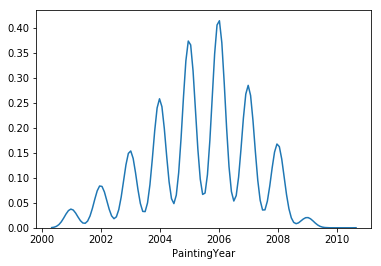

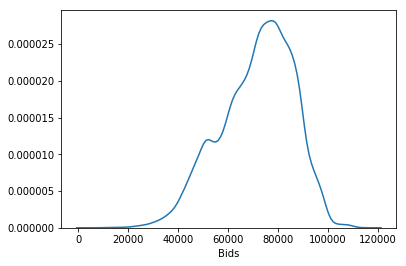

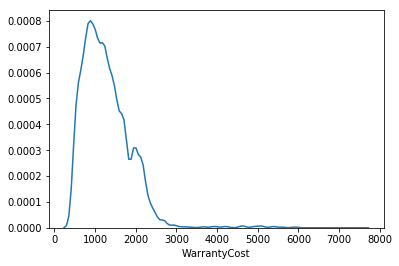

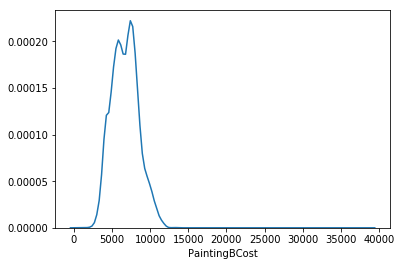

In [4]:
sns.distplot(x_train.PaintingYear, hist=False, rug=False)
plt.show()
sns.distplot(x_train.Bids, hist=False, rug=False)
plt.show()
sns.distplot(x_train.WarrantyCost, hist=False, rug=False)
plt.show()
sns.distplot(x_train.PaintingBCost, hist=False, rug=False)
plt.show()

### drop the ID variable

In [5]:
del x_train["RT13Id"]

### use NLP to extract T1-T13 from painting name and subtype, create dummies for each

In [6]:
t1 = x_train["PaintingName"].str.findall("([T]\d+)")
t2 = x_train["SubType"].str.findall("([T]\d+)")
t = t1+t2
dum_t = t.str.join(sep=',').str.get_dummies(sep=',')

### use NLP extract I4,I-4,I 4,I6,I-6,I 6 from painting name, create dummies for each

In [7]:
qc = x_train["PaintingName"].str.findall("(I[4,6]+|I-[4,6]+|I\s[4,6]+)")
dum_qc = qc.str.join(sep='').str.get_dummies()

###  use NLP extract genre,history,still life,real life,landscape,portrait and fine art from subtype, create dummies

In [8]:
x_train["SubType"] = x_train.loc[:,"SubType"].str.lower()
stylelist = ["genre", "history", "still life", "real life", "landscape", "portrait", "fine art"]
style = x_train.loc[:,"SubType"].str.extract('(' + '|'.join(stylelist) + ')', expand=False)
dum_style = style.str.join(sep='').str.get_dummies()

### split purchase date into year, month and day of week, create dummies for more variables

In [9]:
x_train_dum = pd.get_dummies(x_train, prefix='auct_', columns=["Auction"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='mkt_', columns=["Market"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='mat_', columns=["FrameType"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='nat_', columns=["Nationality"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='s_', columns=["Size"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='t3_', columns=["TopThreeNYCName"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='dm_', columns=["PRIMEUNIT"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='grt_', columns=["AUCGUART"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='pty_', columns=["PaintingYear"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='pta_', columns=["PaintingAge"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='a_', columns=["Artist"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='c_', columns=["CanvasColor"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='tm_', columns=["Trim"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='b_', columns=["BYRNO"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='st_', columns=["VNST"])

x_train_dum['puryr'] = x_train_dum['PurchDate'].map(lambda x: x.year)
x_train_dum['purmo'] = x_train_dum['PurchDate'].map(lambda x: x.month)
x_train_dum['purdow'] = x_train_dum['PurchDate'].dt.weekday

x_train_dum = pd.get_dummies(x_train_dum, prefix='py_', columns=["puryr"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='pm_', columns=["purmo"])
x_train_dum = pd.get_dummies(x_train_dum, prefix='pd_', columns=["purdow"])

### create purchase price to warranty ratio

In [10]:
x_train_dum['ptw'] = x_train.PaintingBCost/x_train.WarrantyCost

### create auction price to bid ratio

In [11]:
x_train_dum['ptb'] = x_train.MMRAcquisitionAuctionCleanPrice/x_train.Bids

### check if there is any N/A in dataset, fill with 0 if true

In [12]:
x_train_dum.isnull().values.any()
x_train_dum = x_train_dum.fillna(0)

### confirm purchase price to warranty ratio is not similar to price to bid ratio

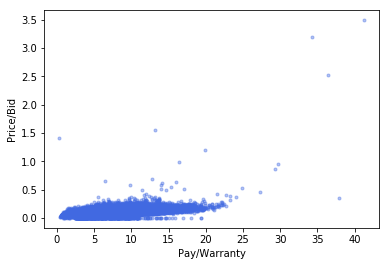

In [13]:
plt.plot(x_train_dum['ptw'], x_train_dum['ptb'], marker='.',
         linestyle='none', color='royalblue', alpha=0.4)
plt.xlabel('Pay/Warranty')
plt.ylabel('Price/Bid')
plt.show()

### delete irrelevant columns

In [14]:
x_train_dum = x_train_dum.drop(['IsBadBuy', 'PurchDate', 'PaintingName', 'SubType', 'FrameTypeID',
                                'Bids', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                               'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 
                               'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
                               'MMRCurrentRetailCleanPrice', 'VNZIP1', 'PaintingBCost', 'WarrantyCost'], axis=1)

### set random forest classifer, train the model

In [15]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, random_state=1)
rfc.fit(x_train_dum, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### cross validation on train data

In [16]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(rfc, x_train_dum, y_train, cv=3, scoring='accuracy')
print("Cross-validated scores:", scores)

Cross-validated scores: [0.88556958 0.88548778 0.8872495 ]


### calculate importance scores of variables

In [17]:
ipt = list(zip(x_train_dum, rfc.feature_importances_))
ipt = sorted(ipt, key = lambda x: x[1], reverse = True)
ipt[0:6]

[('ptb', 0.085324688190428),
 ('ptw', 0.08010919472228034),
 ('mat__Metal', 0.04141105200676476),
 ('mat__Wood', 0.03254819731004254),
 ('c__SILVER', 0.013478894104199824),
 ('pd__2', 0.012888683300003667)]

### filter variables with scores > 0.1%

In [18]:
keep=[]
for i in range((len(ipt)-1)):
    if ipt[i][1] > 0.001:
        keep.append(ipt[i][0])
x_train_dum_f1 = x_train_dum.loc[:,x_train_dum.columns.isin(keep)]

### train the model second time

In [19]:
rfc.fit(x_train_dum_f1, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### cross validation second time

In [20]:
scores = cross_val_score(rfc, x_train_dum_f1, y_train, cv=3, scoring='accuracy')
print("Cross-validated scores:", scores)

Cross-validated scores: [0.89276277 0.89224106 0.89246128]


### clean the test data in consistent with the train data

In [21]:
t1 = x_test["PaintingName"].str.findall("([T]\d+)")
t2 = x_test["SubType"].str.findall("([T]\d+)")
t = t1+t2
dum_t = t.str.join(sep=',').str.get_dummies(sep=',')

qc = x_test["PaintingName"].str.findall("(I[4,6]+|I-[4,6]+|I\s[4,6]+)")
dum_qc = qc.str.join(sep='').str.get_dummies()

x_test["SubType"] = x_test.loc[:,"SubType"].str.lower()
stylelist = ["genre", "history", "still life", "real life", "landscape", "portrait", "fine art"]
style = x_test.loc[:,"SubType"].str.extract('(' + '|'.join(stylelist) + ')', expand=False)
dum_style = style.str.join(sep='').str.get_dummies()

x_test_dum = pd.get_dummies(x_test, prefix='auct_', columns=["Auction"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='mkt_', columns=["Market"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='mat_', columns=["FrameType"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='nat_', columns=["Nationality"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='s_', columns=["Size"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='t3_', columns=["TopThreeNYCName"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='dm_', columns=["PRIMEUNIT"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='grt_', columns=["AUCGUART"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='pty_', columns=["PaintingYear"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='pta_', columns=["PaintingAge"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='a_', columns=["Artist"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='c_', columns=["CanvasColor"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='tm_', columns=["Trim"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='b_', columns=["BYRNO"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='st_', columns=["VNST"])

x_test_dum['puryr'] = x_test_dum['PurchDate'].map(lambda x: x.year)
x_test_dum['purmo'] = x_test_dum['PurchDate'].map(lambda x: x.month)
x_test_dum['purdow'] = x_test_dum['PurchDate'].dt.weekday

x_test_dum = pd.get_dummies(x_test_dum, prefix='py_', columns=["puryr"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='pm_', columns=["purmo"])
x_test_dum = pd.get_dummies(x_test_dum, prefix='pd_', columns=["purdow"])

x_test_dum['ptw'] = x_test.PaintingBCost/x_test.WarrantyCost

x_test_dum['ptb'] = x_test.MMRAcquisitionAuctionCleanPrice/x_test.Bids

x_test_dum.isnull().values.any()
x_test_dum = x_test_dum.fillna(0)

x_test_dum = x_test_dum.drop(['IsBadBuy', 'PurchDate', 'PaintingName', 'SubType', 'FrameTypeID',
                                'Bids', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                               'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 
                               'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
                               'MMRCurrentRetailCleanPrice', 'VNZIP1', 'PaintingBCost', 'WarrantyCost'], axis=1)

### filter the significant variables from test data

In [22]:
x_test_dum_f1 = x_test_dum.loc[:,x_test_dum.columns.isin(keep)]

### predict labels of test data

In [23]:
pred = rfc.predict(x_test_dum_f1)

### calculate accuracy of predicions

In [24]:
from sklearn.metrics import accuracy_score
print('The accuracy of the RFC model on test data: ', str(round(accuracy_score(y_test, pred)*100,3)),'%')

The accuracy of the RFC model on test data:  89.714 %


## 2. XGBoost Classifier

### sort data by column names for xgboost package

In [25]:
x_train_dum_f1 = x_train_dum_f1.reindex(sorted(x_train_dum_f1.columns), axis=1)
x_test_dum_f1 = x_test_dum_f1.reindex(sorted(x_test_dum_f1.columns), axis=1)

### train xgboost model on the filtered variables, return accuracy score

In [26]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=5,
                     min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                     objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgbc.fit(x_train_dum_f1, y_train, eval_metric='auc')
pred_xgb = xgbc.predict(x_test_dum_f1)
print('The accuracy of the XGB model on test data: ', str(round(accuracy_score(y_test, pred_xgb)*100,3)),'%')

The accuracy of the XGB model on test data:  90.331 %
